# Monte Carlo Tennis Simulations

There are two complementary approaches to computing the probability of winning a game, tiebreak, set, or match in tennis.

**Path enumeration**  
All possible score paths are enumerated, and the probability of winning is obtained by summing over these paths. This approach relies on closed-form expressions for deuce and tiebreak scenarios.

**Monte Carlo simulation**  
A large number of games, tiebreaks, sets, or matches are simulated by randomly sampling each point outcome according to the players’ probabilities of winning a point on serve. The win probability is then estimated as the fraction of simulated outcomes won.

In Notebooks 1–4, we focused on the path enumeration approach:
- [1 - Game Win Probability](1%20-%20Game%20Win%20Probability.ipynb)
- [2 - Tiebreak Win Probability](2%20-%20Tiebreak%20Win%20Probability.ipynb)
- [3 - Set Win Probability](3%20-%20Set%20Win%20Probability.ipynb)
- [4 - Match Win Probability](4%20-%20Match%20Win%20Probability.ipynb)

In this notebook, we turn to the second approach. We perform Monte Carlo simulations and compare the resulting probability estimates with those obtained via path enumeration, validating that both methods produce consistent results.

## Setup and Imports

In [1]:
from matplotlib import pyplot as plt
from itertools  import cycle
import numpy as np
import os, sys, time

# add path to the 'tennis_lab' package if not in PYTHONPATH already 
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from tennis_lab.core.game_score     import GameScore
from tennis_lab.core.match_format   import MatchFormat
from tennis_lab.core.match_score    import MatchScore
from tennis_lab.core.set_score      import SetScore
from tennis_lab.core.tiebreak_score import TiebreakScore

from tennis_lab.montecarlo.game_simulation     import probabilityServerWinsGame as probabilityServerWinsGame_MC
from tennis_lab.montecarlo.tiebreak_simulation import probabilityP1WinsTiebreak as probabilityP1WinsTiebreak_MC
from tennis_lab.montecarlo.set_simulation      import probabilityP1WinsSet      as probabilityP1WinsSet_MC
from tennis_lab.montecarlo.match_simulation    import probabilityP1WinsMatch    as probabilityP1WinsMatch_MC

from tennis_lab.paths.game_probability     import loadCachedFunction as loadCachedFunction_Game
from tennis_lab.paths.tiebreak_probability import loadCachedFunction as loadCachedFunction_Tiebreak
from tennis_lab.paths.set_probability      import probabilityP1WinsSet
from tennis_lab.paths.match_probability    import probabilityP1WinsMatch

## Game Simulation

This section validates game level probability calculations. We simulate thousands of games and compare the fraction of games won by the server with the corresponding theoretical (cached) values.

The Monte Carlo function `probabilityServerWinsGame_MC` simulates games point by point, randomly determining the winner of each point based on the probability of winning a point on serve. The theoretical values are obtained from path enumeration using a closed form solution for deuce scenarios.

In [ ]:
# MONTE-CARLO SIMULATION: GAME
# Calculate the probability that the player serving wins the game using MC simulation.
# Compare results with the cached values previously calculated using the path enumeration method.
t0 = time.time()
    
# Calculate the win probability from multiple initial scores.
INIT_SCORES    = [GameScore(2,0), GameScore(0,0), GameScore(0,2)] 
PLAYER_SERVING = 1

# Probability that the player serving wins the point.
Ps = np.linspace(0, 1, 30)

# Carry out MC simulation
N = 10000     # how many games to simulate for each probability 'p'
Ys = [[probabilityServerWinsGame_MC(initScore, PLAYER_SERVING, p, N) for p in Ps] for initScore in INIT_SCORES]

# Load cached data previously calculated using the path enumeration method.
Ts = []
for score in INIT_SCORES:
    cachedFunc = loadCachedFunction_Game(score, PLAYER_SERVING)        
    Ts.append([cachedFunc(p) for p in Ps])

# Display results
plt.xlabel("probability of winning the point on serve")
plt.ylabel("probability of winning the game on serve")
plt.title ("Probability of Winning the Game on Serve - MC Simulation")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)

colors1 = cycle(["lightblue", "lightgrey", "lightgreen"])
colors2 = cycle(["blue", "grey", "green"])
for i, ys in enumerate(Ys):
    label = f"simulation,     initScore={INIT_SCORES[i].asPoints(1)}"
    plt.scatter(Ps, ys, s=70, facecolors=next(colors1), edgecolors=next(colors2), label=label, alpha=0.7)

colors1 = cycle(["blue", "grey", "green"])
for i, ts in enumerate(Ts):
    label = f"path method, initScore={INIT_SCORES[i].asPoints(1)}"
    plt.plot(Ps, ts, linewidth=0.75, color=next(colors1), label=label)

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

## Tiebreak Simulation
We consider two complementary scenarios.

**Scenario 1** fixes the starting score at 0–0 and varies Player 2’s probability of winning a point on serve. This isolates the impact of the opponent’s serve strength on the overall tiebreak win probability.

**Scenario 2** fixes Player 2’s serve probability and varies the starting score within the tiebreak. This allows us to study how the current score and the implied serving order influence the probability of winning from different points in the tiebreak.

In [ ]:
# MONTE-CARLO SIMULATION: TIEBREAKS - Scenarios 1
# Calculate the probability that Player1 wins the tiebreak by MC simulation.
# Compare results with the cached values previously calculated using the path enumeration method.
# Start at 0-0 and simulates for multiple probabilities that Player2 wins the point on serve.
t0 = time.time()

IS_SUPER       = False
INIT_SCORE     = TiebreakScore(0, 0, IS_SUPER)
PLAYER_SERVING = 1            # which player is serving next point
P1s = np.linspace(0, 1, 20)   # probability that Player1 wins the point when serving (x-axis)
P2s = [0.15, 0.50, 0.85]      # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 4000   # how many tiebreaks to simulate for each probability pair (P1, P2)
Ys = {p2: [probabilityP1WinsTiebreak_MC(INIT_SCORE, PLAYER_SERVING, p1, p2, N) for p1 in P1s] for p2 in P2s}

# Load cached data previously calculated using the path enumeration method.
cachedFunc = loadCachedFunction_Tiebreak(INIT_SCORE, PLAYER_SERVING)
Ts = {p2: [cachedFunc(p1, p2) for p1 in P1s] for p2 in P2s}

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the tiebreak")
plt.title ("Probability of Player1 Winning the Tiebreak - MC Simulation", fontsize=10)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles  = cycle(['-', '--', ':'])
markers = cycle(['o', 's' , 'p']) 

for p2 in P2s:   # plot a family of curves
    plt.scatter(P1s, Ys[p2], s=60, facecolors='lightgrey', marker=next(markers), edgecolors='black', alpha=0.7, label=f"simulation,    p2={p2}")
    plt.plot   (P1s, Ts[p2], linewidth=0.8, color='black', linestyle=next(styles), label=f"path mehod, p2={p2}")

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

In [ ]:
# MONTE-CARLO SIMULATION: TIEBREAKS - Scenario 2
# Calculate the probability that Player1 wins the tiebreak by MC simulation.
# Compare results with the cached values previously calculated using the path enumeration method.
# Fix the probability that Player2 wins a point when serving and carry out the simulation from
# multiple initial scores. 
t0 = time.time()

IS_SUPER    = False
INIT_SCORES = [TiebreakScore(2, 0, IS_SUPER), TiebreakScore(0, 5, IS_SUPER),
               TiebreakScore(3, 3, IS_SUPER), TiebreakScore(4, 6, IS_SUPER)]
PLAYER_SERVING = 2            # which player is serving next point
P1s = np.linspace(0, 1, 20)   # probability that Player1 wins the point when serving (x-axis)
P2  = 0.5                     # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 4000   # how many tiebreaks to simulate for each probability pair (P1, P2)
Ys = {score: [probabilityP1WinsTiebreak_MC(score, PLAYER_SERVING, p1, P2, N) for p1 in P1s] for score in INIT_SCORES}

# Load cached data previously calculated by adding up score scenario probabilities
Ts = {}
for score in INIT_SCORES:
    cachedFunc = loadCachedFunction_Tiebreak(score, PLAYER_SERVING)
    Ts[score] = [cachedFunc(p1, P2) for p1 in P1s]

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the tiebreak")
plt.title ("Probability of Player1 Winning the Tiebreak - MC Simulation")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles = cycle(['-', '--', '-.', ':'])
markers = cycle(['o', 's' , 'p', 'd'])

for score in INIT_SCORES:   # plot a family of curves
    plt.scatter(P1s, Ys[score], s=50, facecolors='lightgrey', marker=next(markers), edgecolors='black', alpha=0.7, label=f"simulation,    init_score={score}")
    plt.plot   (P1s, Ts[score], linewidth=0.8, color='black', linestyle=next(styles), label=f"path mehod, init_score={score}")

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

## Set Simulation

Set simulations are computationally more expensive since each set contains multiple games (and potentially a tiebreak).<br>
The Monte Carlo approach simulates every point within every game of the set.

**Scenario 1** starts from 0-0 and varies the opponent's serve-winning probability.  
**Scenario 2** explores different starting scores within the set (e.g., mid-game scores like 30-0).

In [ ]:
# MONTE-CARLO SIMULATION: SET - Part 1
# Calculate the probability that Player1 wins the set by MC simulation.
# The granularity of the MC simulation is 'point' (not 'game').
# Compare results with the cached values previously calculated using the path enumeration method.
# Start at 0-0 and simulates for multiple probabilities that Player2 wins the point on serve.
t0 = time.time()

INIT_SCORE     = SetScore(0, 0, isFinalSet=False)
PLAYER_SERVING = 1            # which player is serving next point
P1s = np.linspace(0, 1, 20)   # probability that Player1 wins the point when serving (x-axis)
P2s = [0.25, 0.50, 0.75]      # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 1000    # how many sets to simulate for each probability pair (P1, P2)
Ys = {}
for p2 in P2s:
    Ys[p2] = [probabilityP1WinsSet_MC(INIT_SCORE, PLAYER_SERVING, p1, p2, N) for p1 in P1s]

# Calculate theoretical values (note: probabilityP1WinsSet expects an iterable of P1 values)
Ts = {}
for p2 in P2s:
    Ts[p2] = probabilityP1WinsSet(INIT_SCORE, PLAYER_SERVING, P1s, p2)

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the set")
plt.title ("Probability of Player1 Winning the Set - MC Simulation")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles  = cycle(['-', '--', ':'])
markers = cycle(['o', 's' , 'p'])

for idx, p2 in enumerate(P2s):   # plot a family of curves
    plt.scatter(P1s, Ys[p2], s=50, facecolors='lightgrey', marker=next(markers), edgecolors='black', alpha=0.7, label=f"simulation,    p2={p2}")
    plt.plot   (P1s, Ts[p2], linewidth=0.8, color='black', linestyle=next(styles), label=f"path mehod, p2={p2}")

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

In [ ]:
# MONTE-CARLO SIMULATION: SETS - Part 2
# Calculate the probability that Player1 wins the set by MC simulation.
# The granularity of the MC simulation is 'point' (not 'game').
# Compare results with the cached values previously calculated using the path enumeration method.
# Fix the probability that Player2 wins a point when serving and carry out the simulation from
# multiple initial scores. 
t0 = time.time()

INIT_SCORES = [SetScore(0, 0, False, MatchFormat(), GameScore(0, 0)), 
               SetScore(0, 0, False, MatchFormat(), GameScore(2, 0))]
PLAYER_SERVING = 1            # which player is serving next point
P1s = np.linspace(0, 1, 20)   # probability that Player1 wins the point when serving (x-axis)
P2  = 0.5                     # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 1000    # how many sets to simulate for each probability pair (P1, P2)
Ys = {}
for score in INIT_SCORES:
    Ys[score] = [probabilityP1WinsSet_MC(score, PLAYER_SERVING, p1, P2, N) for p1 in P1s]

# Calculate theoretical values (note: probabilityP1WinsSet expects an iterable of P1 values)
Ts = {}
for score in INIT_SCORES:
    Ts[score] = probabilityP1WinsSet(score, PLAYER_SERVING, P1s, P2)

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the set")
plt.title (f"Probability of Player1 Winning the Set - MC Simulation (p2={P2})")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles  = cycle(['-', '--', '-.', ':'])
markers = cycle(['o', 's' , 'p', 'd'])

for score in INIT_SCORES:   # plot a family of curves
    plt.scatter(P1s, Ys[score], s=40, facecolors='lightgrey', marker=next(markers), edgecolors='black', alpha=0.7, label=f"simulation,    init_score={score}")
    plt.plot   (P1s, Ts[score], linewidth=0.8, color='black', linestyle=next(styles), label=f"path mehod, init_score={score}")

plt.legend(fontsize=7)
print(f"Simulation time: {time.time() - t0:.2f}s")

## Match Simulation

Full match simulations are the most computationally intensive, as they simulate every point of every game of every set.<br> 
A best-of-3 match typically contains 150-250 points; a best-of-5 match can have 300+ points.

**Scenario 1** simulates best-of-3 matches starting from 0-0 with varying opponent serve strength.  
**Scenario 2** simulates best-of-5 matches from various set scores (e.g., 1-0, 2-0, 0-2, 2-2).

In [ ]:
# MONTE-CARLO SIMULATION: MATCH - Scenario 1
# Calculate the probability that Player1 wins the match by MC simulation.
# The granularity of the MC simulation is 'point' (not 'game' or 'set').
# Compare results with the cached values previously calculated using the path enumeration method.
# Start at 0-0 and simulates for multiple probabilities that Player2 wins the point on serve.
t0 = time.time()

BEST_OF        = 3
INIT_SCORE     = MatchScore(0, 0, MatchFormat(bestOfSets=BEST_OF))
PLAYER_SERVING = 1            # which player is serving next point
P1s = np.linspace(0, 1, 30)   # probability that Player1 wins the point when serving (x-axis)
P2s = [0.30, 0.50, 0.7]       # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 500    # how many matches to simulate for each probability pair (P1, P2)
Ys = {}
for p2 in P2s:
    Ys[p2] = [probabilityP1WinsMatch_MC(INIT_SCORE, PLAYER_SERVING, p1, p2, N) for p1 in P1s]

# Calculate theoretical values (note: probabilityP1WinsMatch expects an iterable of P1 values)
Ts = {}
for p2 in P2s:
    Ts[p2] = probabilityP1WinsMatch(INIT_SCORE, PLAYER_SERVING, P1s, p2)

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the match")
plt.title ("Probability of Player1 Winning the Match - MC Simulation")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles  = cycle(['-', '--', ':'])
markers = cycle(['o', 's' , 'p'])

for idx, p2 in enumerate(P2s):   # plot a family of curves
    plt.scatter(P1s, Ys[p2], s=40, facecolors='lightgrey', marker=next(markers), edgecolors='black', alpha=0.7,  label=f"simulation,    p2={p2}")
    plt.plot   (P1s, Ts[p2], linewidth=0.8, color='black', linestyle=next(styles), label=f"path method, p2={p2}")

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

In [ ]:
# MONTE-CARLO SIMULATION: MATCH - Scenario 2
# Calculate the probability that Player1 wins the match by MC simulation.
# The granularity of the MC simulation is 'point' (not 'game' or 'set').
# Compare results with the cached values previously calculated using the path enumeration method.
# Fix the probability that Player2 wins a point when serving and carry out the simulation from
# multiple initial scores. 
t0 = time.time()

BEST_OF     = 5
MF          = MatchFormat(bestOfSets=BEST_OF)
INIT_SCORES = [MatchScore(1, 0, MF), MatchScore(2, 0, MF),
               MatchScore(0, 2, MF), MatchScore(2, 2, MF)]
PLAYER_SERVING = 1            # which player is serving next point
P1s = np.linspace(0, 1, 30)   # probability that Player1 wins the point when serving (x-axis)
P2  = 0.50                    # probability that Player2 wins the point when serving (parameter)

# Carry out MC simulation
N = 500    # how many matches to simulate for each probability pair (P1, P2)
Ys = {}
for score in INIT_SCORES:
    Ys[score] = [probabilityP1WinsMatch_MC(score, PLAYER_SERVING, p1, P2, N) for p1 in P1s]

# Calculate theoretical values (note: probabilityP1WinsMatch expects an iterable of P1 values)
Ts = {}
for score in INIT_SCORES:
    Ts[score] = probabilityP1WinsMatch(score, PLAYER_SERVING, P1s, P2)

# Display results
plt.xlabel("probability of winning the point on serve for Player1")
plt.ylabel("probability of winning the match")
plt.title (f"Probability of Player1 Winning the Match - MC Simulation (p2={P2})")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(linewidth=0.2)
styles  = cycle(['-', '--', '-.', ':'])
markers = cycle(['o', 's' , 'p', 'd'])

for score in INIT_SCORES:   # plot a family of curves
    sets1, sets2 = score.sets(1)
    label = f"simulation init score = {sets1}-{sets2}, 0-0, 0-0"
    plt.scatter(P1s, Ys[score], s=40, facecolors='lightgrey', edgecolors='black', alpha=0.7)
    plt.plot   (P1s, Ts[score], linewidth=0.8, color='black', linestyle=next(styles), label=label)

plt.legend(fontsize=6)
print(f"Simulation time: {time.time() - t0:.2f}s")

## Match Length Analysis

How does match length (in number of points) depend on the players' serve-winning probabilities?

We simulate many matches across a grid of (P1, P2) values and measure the average number of
points played. Matches between evenly-matched players tend to be longer, while mismatches
end quickly.

Simulation time: 12.22s              


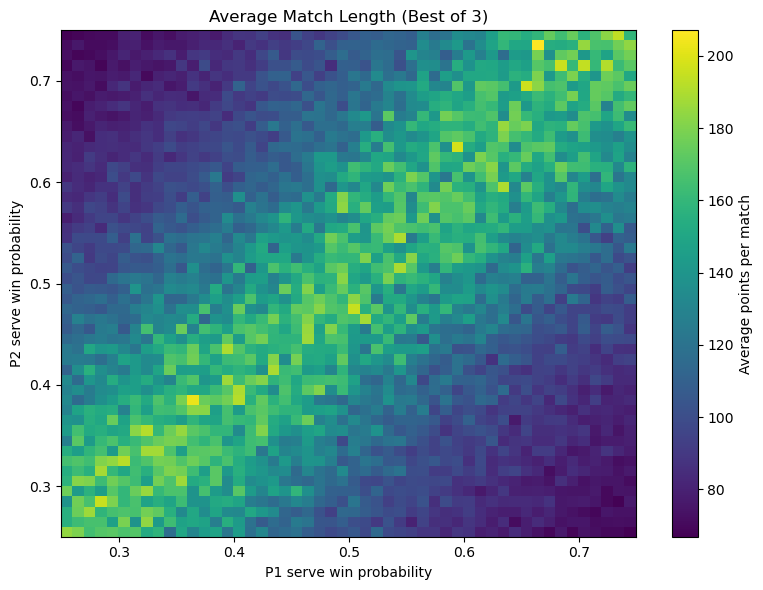

In [19]:
# Simulate matches and calculate average match length
import random
from tennis_lab.core.match import Match

t0 = time.time()

# Define match format
BEST_OF = 3
matchFormat = MatchFormat(bestOfSets=BEST_OF)

# Define grid of serve probabilities
P1s = np.linspace(0.25, 0.75, 50)
P2s = np.linspace(0.25, 0.75, 50)

# Numnber of matches to simulate per (P1, P2) pair
N = 10  

def simulateMatchLength(matchFormat, p1, p2, numSims):
    """Simulate matches and return mean number of points played."""
    lengths = []
    for _ in range(numSims):
        match = Match(playerServing=1, matchFormat=matchFormat)
        while not match.isOver:
            server = match.servesNext
            prob = p1 if server == 1 else p2
            winner = server if random.random() < prob else (3 - server)
            match.recordPoint(winner)
        lengths.append(len(match.pointHistory))
    return np.mean(lengths)

# Build the heatmap data
matchLengths = np.zeros((len(P2s), len(P1s)))
for i, p2 in enumerate(P2s):
    for j, p1 in enumerate(P1s):
        print(f"\rCalculating: p1={p1:.2f},p2={p2:.2f}...", end='', flush=1)
        matchLengths[i, j] = simulateMatchLength(matchFormat, p1, p2, N)
print(f"\rSimulation time: {time.time() - t0:.2f}s              ")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matchLengths, origin='lower', aspect='auto',
               extent=[P1s[0], P1s[-1], P2s[0], P2s[-1]], cmap='viridis')
plt.colorbar(im, label='Average points per match')
ax.set_xlabel("P1 serve win probability", fontsize=10)
ax.set_ylabel("P2 serve win probability", fontsize=10)
ax.set_title(f"Average Match Length (Best of {BEST_OF})", fontsize=12)
plt.tight_layout()
plt.show()